In [384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [385]:
archivo = 'csv_creados/Data_Argentina_Relative_Terms.csv'
df = pd.read_csv(archivo)
df.head(2)

,year,GDP_Current_gr,GDP_Constant_gr,Broad_Money_gr,Inflation,Velocity_Money_gr
0,1961-12-31,0.268410,0.054278,-0.003597,0.203107,0.272007
1,1962-12-31,0.277738,-0.008520,0.101083,0.288718,0.176655


In [386]:
df.columns

Index(['year', 'GDP_Current_gr', 'GDP_Constant_gr', 'Broad_Money_gr',
       'Inflation', 'Velocity_Money_gr'],
      dtype='object')

In [387]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               63 non-null     object 
 1   GDP_Current_gr     63 non-null     float64
 2   GDP_Constant_gr    63 non-null     float64
 3   Broad_Money_gr     63 non-null     float64
 4   Inflation          63 non-null     float64
 5   Velocity_Money_gr  63 non-null     float64
dtypes: float64(5), object(1)
memory usage: 3.1+ KB


In [388]:
df['year'] = pd.to_datetime(df['year'])

In [389]:
df.isnull().sum()

year                 0
GDP_Current_gr       0
GDP_Constant_gr      0
Broad_Money_gr       0
Inflation            0
Velocity_Money_gr    0
dtype: int64

In [390]:
df.describe()

,year,GDP_Current_gr,GDP_Constant_gr,Broad_Money_gr,Inflation,Velocity_Money_gr
count,63,63.000000,63.000000,63.000000,63.000000,63.000000
mean,1992-12-30 14:51:25.714285696,1.591292,0.023335,1.374111,1.604749,0.217181
min,1961-12-31 00:00:00,-0.054563,-0.108945,-0.194362,-0.035611,-0.668046
25%,1977-07-01 12:00:00,0.201713,-0.020096,0.211689,0.151588,-0.140163
50%,1992-12-31 00:00:00,0.331365,0.028118,0.349018,0.288718,-0.033770
75%,2008-07-01 00:00:00,0.966935,0.065438,1.115077,1.005334,0.073334
max,2023-12-31 00:00:00,28.209270,0.107180,22.351819,30.460912,9.113007
std,NaN,4.390996,0.054967,3.230300,4.660917,1.389316


Distribution of target variable

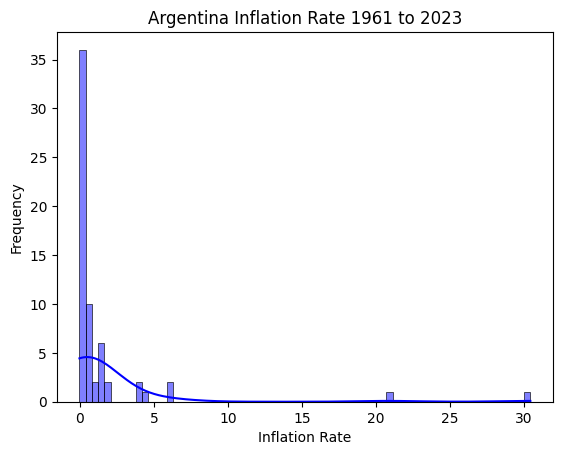

In [391]:
sns.histplot(df['Inflation'], kde=True, color='blue')
plt.title('Argentina Inflation Rate 1961 to 2023')
plt.xlabel('Inflation Rate')
plt.ylabel('Frequency')
plt.show()

In [392]:
IQR_Inflation_Rate = df['Inflation'].quantile(0.75) - df['Inflation'].quantile(0.25)
IQR_Inflation_Rate

np.float64(0.853746082987118)

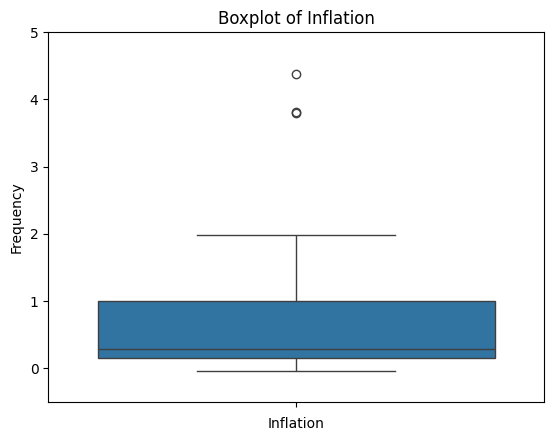

In [393]:
sns.boxplot(df['Inflation'])
plt.title('Boxplot of Inflation')
plt.xlabel('Inflation')
plt.ylabel('Frequency')
plt.ylim(-0.5, 5)
plt.show()

Managing outliers at the moment

In [394]:
df1 = df.copy()

upper_bond = 4*IQR_Inflation_Rate + df1['Inflation'].quantile(0.75)
lower_bond = df1['Inflation'].quantile(0.25) - 4*IQR_Inflation_Rate

df2 = df1[(df1['Inflation'] <= upper_bond) & (df1['Inflation'] >= lower_bond)]

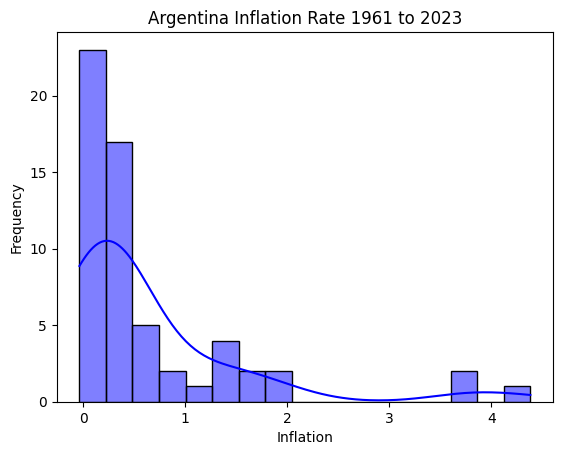

In [395]:
sns.histplot(df2['Inflation'], kde=True, color='blue')
plt.title('Argentina Inflation Rate 1961 to 2023')
plt.xlabel('Inflation')
plt.ylabel('Frequency')
plt.show()

In [396]:
IQR_Inflation_Rate = df1['Broad_Money_gr'].quantile(0.75) - df1['Broad_Money_gr'].quantile(0.25)

upper_bond = 4*IQR_Inflation_Rate + df1['Broad_Money_gr'].quantile(0.75)
lower_bond = df1['Broad_Money_gr'].quantile(0.25) - 4*IQR_Inflation_Rate

df3 = df2[(df2['Broad_Money_gr'] <= upper_bond) & (df2['Broad_Money_gr'] >= lower_bond)]


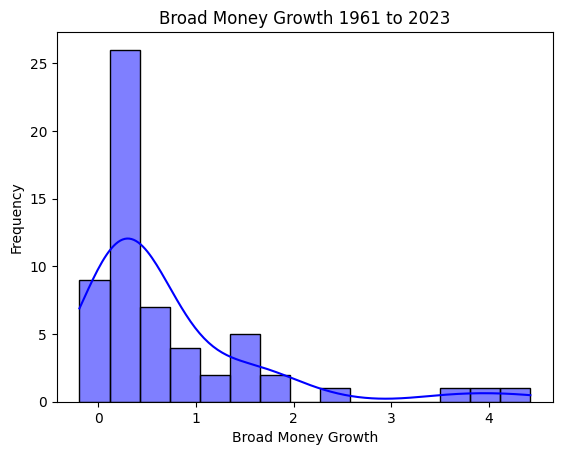

In [423]:
sns.histplot(df3['Broad_Money_gr'], kde=True, color='blue')
plt.title('Broad Money Growth 1961 to 2023')
plt.xlabel('Broad Money Growth')
plt.ylabel('Frequency')
plt.show()

In [397]:
df3.to_csv('csv_creados/df_arc_normalized.csv',index=False)

 ## Correlation Matrix

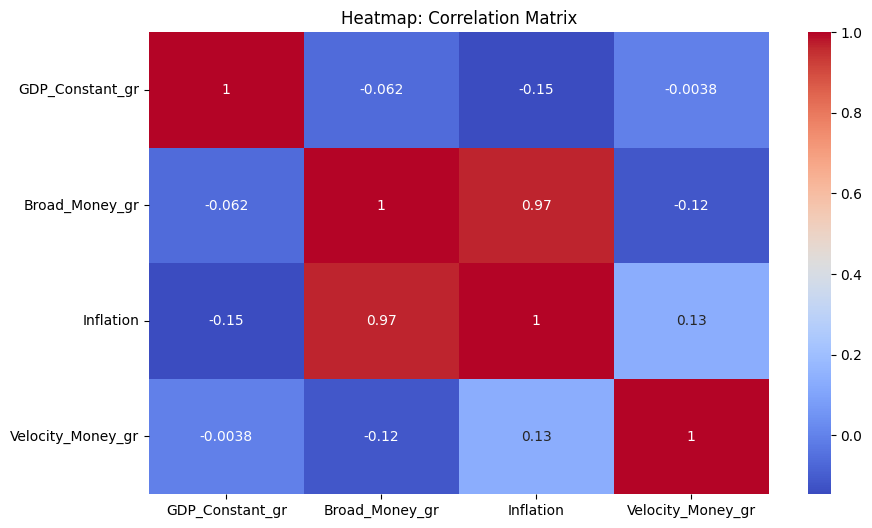

In [398]:
n_columns = ['GDP_Constant_gr', 'Broad_Money_gr', 'Inflation',
       'Velocity_Money_gr']
correlation_matrix = df3[n_columns].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap: Correlation Matrix')
plt.show()

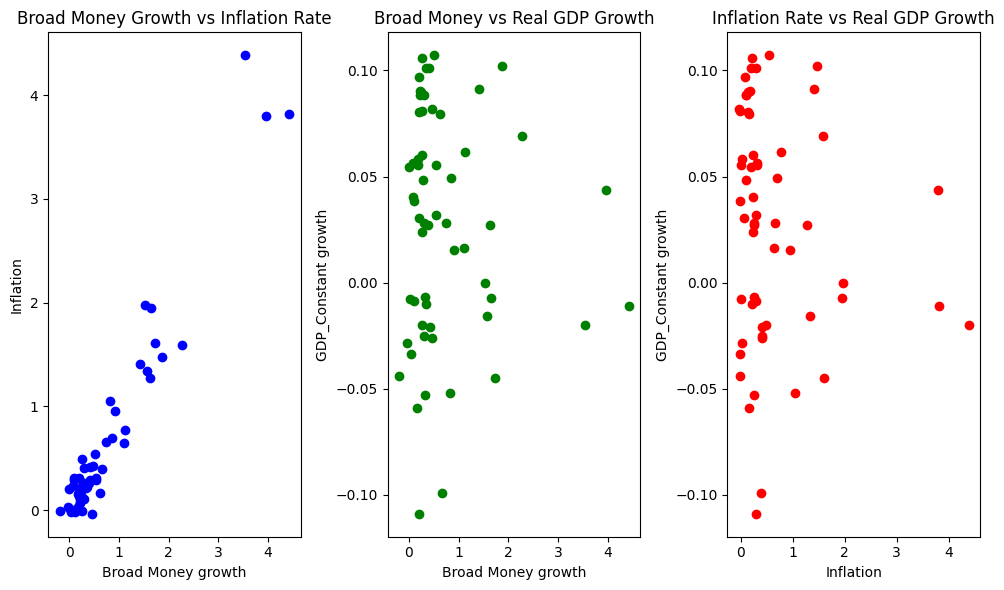

In [399]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

# Primer gráfico: M2 growth vs Inflation Rate
axs[0].scatter(df3['Broad_Money_gr'], df3['Inflation'], color='blue')
axs[0].set_xlabel('Broad Money growth')
axs[0].set_ylabel('Inflation')
axs[0].set_title('Broad Money Growth vs Inflation Rate')

# Segundo gráfico: GDP real vs Inflation Rate
axs[1].scatter(df3['Broad_Money_gr'], df3['GDP_Constant_gr'], color='green')
axs[1].set_xlabel('Broad Money growth')
axs[1].set_ylabel('GDP_Constant growth')
axs[1].set_title('Broad Money vs Real GDP Growth')

# Tercer gráfico: Velocity of M2 vs Inflation Rate
axs[2].scatter(df3['Inflation'], df3['GDP_Constant_gr'], color='red')
axs[2].set_xlabel('Inflation')
axs[2].set_ylabel('GDP_Constant growth')
axs[2].set_title('Inflation Rate vs Real GDP Growth')


plt.tight_layout()
plt.show()


## Linear Regression

In [400]:
X = df3['Broad_Money_gr']
y = df3['Inflation']

In [401]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [402]:
print("Lenght of Train", len(X_train))
print("Lenght of Test", len(X_test))

Lenght of Train 47
Lenght of Test 12


In [403]:
X_train_sm = sm.add_constant(X_train)
y_train = y_train.astype(float)
X_train_sm = X_train_sm.astype(float)

model = sm.OLS(y_train, X_train_sm).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Inflation   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     526.2
Date:                Fri, 09 Aug 2024   Prob (F-statistic):           1.82e-26
Time:                        11:57:22   Log-Likelihood:                -2.8794
No. Observations:                  47   AIC:                             9.759
Df Residuals:                      45   BIC:                             13.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0795      0.050     -1.

In [404]:
X_test_sm = sm.add_constant(X_test)
y_pred = model.predict(X_test_sm)

1. Checking linearity

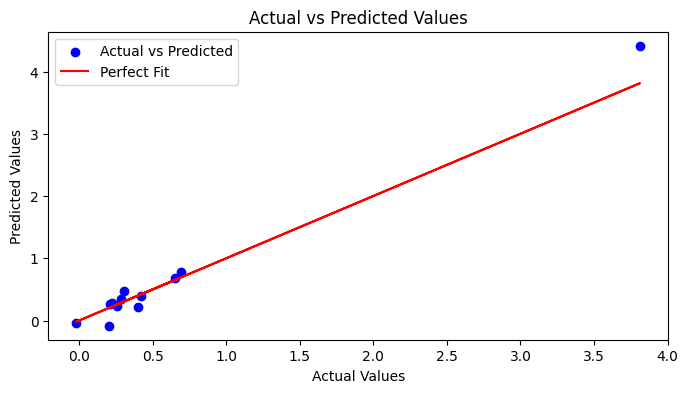

In [405]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, color = 'blue', label = 'Actual vs Predicted' )
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot(y_test, y_test, color='red', label='Perfect Fit')
plt.legend()
plt.show()

2. Checking that residuals are randomly distributed

In [406]:
mean_residuals = np.mean(model.resid)
np.round(mean_residuals,2)

np.float64(0.0)

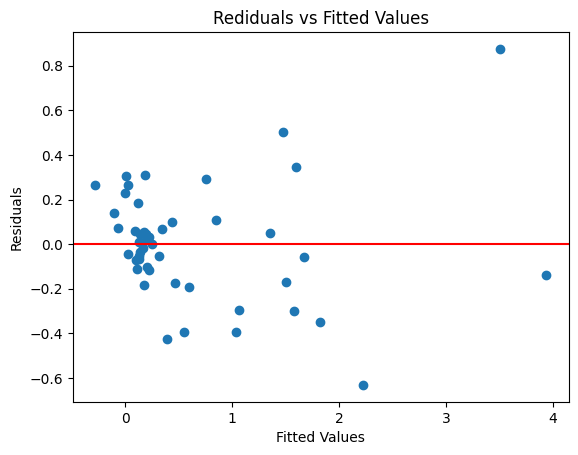

In [407]:
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color = 'red')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Rediduals vs Fitted Values')
plt.show()

3. Checking independecy of Broad Money observations against residuals

In [408]:
correlation = np.corrcoef(X_train, model.resid)[0,1]
print(f"Correlation between Broad Money Growth and residuals: {np.round(correlation,2)}")

Correlation between Broad Money Growth and residuals: 0.0


4. Checking homoscedasticity

In [409]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Realizar la prueba de Breusch-Pagan para medir homoscedasticidad

bp_test = het_breuschpagan(model.resid, model.model.exog)
bp_test_stat, bp_test_p_value = bp_test[1], bp_test[0]

print(f'Breusch-Pagan test p-value: {bp_test_p_value}')

Breusch-Pagan test p-value: 16.84510417004581


There is no significant heteroscedasticity in the model.

5. Checking the normality of the residuals

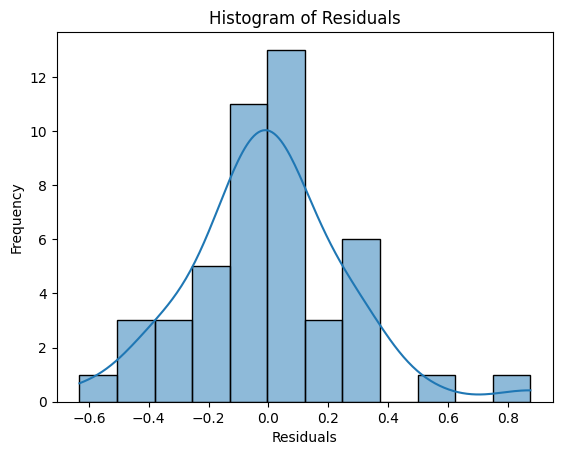

In [410]:
sns.histplot(model.resid, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Normality test of the residuals

In [411]:
from scipy import stats

# Prueba de Shapiro-Wilk
stat, p_value = stats.shapiro(model.resid)

print(f'Statistic: {stat}')
print(f'p-value: {p_value}')

alpha = 0.05
if p_value > alpha:
    print('Los residuos parecen seguir una distribución normal (no se rechaza H0).')
else:
    print('Los residuos no siguen una distribución normal (se rechaza H0).')

Statistic: 0.96221495010534
p-value: 0.1316937770653241
Los residuos parecen seguir una distribución normal (no se rechaza H0).


Alternative regression

In [412]:
X = df3[['Broad_Money_gr']]
y = df3.Inflation


lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
adj_r2 = 1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adj_r2}")

Mean Squared Error: 0.05946122237752801
R-squared: 0.9312438934198938
Adjusted R-squared: 0.9300376459360322


## Granger Causality

ADF test to check if the data series are stationary

In [413]:
from statsmodels.tsa.stattools import adfuller

variables = df[['Broad_Money_gr', 'Inflation']]

# Función para verificar la estacionariedad con la prueba ADF
def check_stationarity(time_series, series_name):
    result = adfuller(time_series)
    adf_statistic = result[0]
    p_value = result[1]
    print(f'{series_name} ADF Statistic: {adf_statistic}')
    print(f'{series_name} p-value: {p_value}')
    if p_value < 0.05:
        print(f'{series_name} es estacionaria\n')
    else:
        print(f'{series_name} no es estacionaria\n')


check_stationarity(variables['Broad_Money_gr'], 'Broad_Money')
check_stationarity(variables['Inflation'], 'Inflation')



Broad_Money ADF Statistic: -4.654151562899428
Broad_Money p-value: 0.00010252445060819894
Broad_Money es estacionaria

Inflation ADF Statistic: -5.13456040708069
Inflation p-value: 1.1940906674110305e-05
Inflation es estacionaria



In [414]:
# Dividimos los datos en entrenamiento y prueba
train_size = int(len(df) * 0.6)  
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Selección de las columnas relevantes
variables_train = train_data[['Broad_Money_gr', 'Inflation']]
variables_test = test_data[['Broad_Money_gr', 'Inflation']]

In [415]:
from statsmodels.tsa.stattools import grangercausalitytests

gc_results_train = grangercausalitytests(variables_train[['Broad_Money_gr', 'Inflation']], 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9960 , p=0.0022  , df_denom=33, df_num=1
ssr based chi2 test:   chi2=11.9957 , p=0.0005  , df=1
likelihood ratio test: chi2=10.3533 , p=0.0013  , df=1
parameter F test:         F=10.9960 , p=0.0022  , df_denom=33, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5701  , p=0.0407  , df_denom=30, df_num=2
ssr based chi2 test:   chi2=8.3303  , p=0.0155  , df=2
likelihood ratio test: chi2=7.4727  , p=0.0238  , df=2
parameter F test:         F=3.5701  , p=0.0407  , df_denom=30, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4685  , p=0.0835  , df_denom=27, df_num=3
ssr based chi2 test:   chi2=9.3255  , p=0.0253  , df=3
likelihood ratio test: chi2=8.2410  , p=0.0413  , df=3
parameter F test:         F=2.4685  , p=0.0835  , df_denom=27, df_num=3


In [416]:
gc_results_test = grangercausalitytests(variables_test[['Broad_Money_gr', 'Inflation']], 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.1370 , p=0.0030  , df_denom=22, df_num=1
ssr based chi2 test:   chi2=12.6557 , p=0.0004  , df=1
likelihood ratio test: chi2=10.2402 , p=0.0014  , df=1
parameter F test:         F=11.1370 , p=0.0030  , df_denom=22, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7746  , p=0.0209  , df_denom=19, df_num=2
ssr based chi2 test:   chi2=12.0623 , p=0.0024  , df=2
likelihood ratio test: chi2=9.7726  , p=0.0075  , df=2
parameter F test:         F=4.7746  , p=0.0209  , df_denom=19, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2771  , p=0.0213  , df_denom=16, df_num=3
ssr based chi2 test:   chi2=18.4449 , p=0.0004  , df=3
likelihood ratio test: chi2=13.5440 , p=0.0036  , df=3
parameter F test:         F=4.2771  , p=0.0213  , df_denom=16, df_num=3


Granger causality found in the training set is confirmed in the test set for the first two lags, indicating that the model is robust in terms of detecting causality for lags 1 and 2. We can say that Inflation is Granger-caused by Money Supply when considering the first two lags.

## Random Forest

In [417]:
from sklearn.ensemble import RandomForestRegressor

X = df[['Broad_Money_gr']]
y = df['Inflation']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.032874080269484976
R-squared: 0.8111257598143947


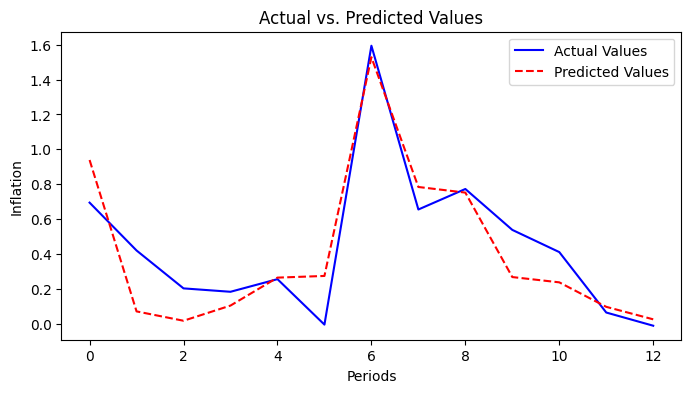

In [418]:
x = np.arange(len(y_test))

# Crear el gráfico
plt.figure(figsize=(8, 4))
plt.plot(x, y_test, color='blue', label='Actual Values')
plt.plot(x, y_pred, color='red', linestyle='--', label='Predicted Values')

# Añadir etiquetas y título
plt.xlabel('Periods')
plt.ylabel('Inflation')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()